In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [3]:
all_chars = string.printable
n_chars   = len(all_chars)
file      = open('./trump.txt', encoding="utf-8").read()
file_len  = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 5569684
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [4]:
# Turning a string into a tensor.
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_chars.index(string[c])
        except:
            continue
    return tensor

In [5]:
def training_set(seq_len, batch_size):
    input = torch.LongTensor(batch_size, seq_len)
    target = torch.LongTensor(batch_size, seq_len)
    for i in range(batch_size):
        start_index  = random.randint(0, file_len - seq_len - 1)
        end_index    = start_index + seq_len + 1
        seq          = file[start_index:end_index]
        input[i]     = char_tensor(seq[:-1])
        target[i]    = char_tensor(seq[1:])
    input  = Variable(input)   # Wrap up the tensor to backpropagate a loss function
    target = Variable(target)  # Wrap up the tensor to backpropagate a loss function
    if torch.cuda.is_available():
        input  = input.cuda()
        target = target.cuda()
    return input, target

In [6]:
class charRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model='gru', n_layers=1):
        # Initialization.
        super(charRNN, self).__init__()
        self.model = model.lower()
        self.input_size  = input_size        # Input size: Number of unique chars.
        self.hidden_size = hidden_size       # Hidden size: 100.
        self.output_size = output_size       # Output size: Number of unique chars.
        self.n_layers = n_layers
        
        # Use Word Embeddings to encode semantic similarity in words instead of one-hot
        self.embeds = nn.Embedding(input_size, hidden_size)
        if self.model == "rnn":
            self.rnn = nn.RNN(input_size, hidden_size, n_layers)
        elif self.model == "gru":
            self.rnn = nn.GRU(input_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(input_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        # Forward function.
        batch_size = input.size(0)
        encoded = self.embeds(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.embeds(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def init_hidden(self, batch_size):
        # Initial hidden state.
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [7]:
def train_step(net, opt, input, target):
    hidden = net.init_hidden(batch_size) # Initial hidden state.
    if torch.cuda.is_available():
        hidden = hidden.cuda()     
    net.zero_grad()                      # Clear the gradient.
    loss = 0                             # Initial loss.
    
    for t in range(seq_len):            # For each one in the input sequence.
        output, hidden = net(input[:,t], hidden)
        loss += loss_func(output.view(batch_size, -1), target[:,t])
        
    loss.backward()                      # Backward. 
    opt.step()                           # Update the weights.
    
    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [8]:
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden = net.init_hidden(1)
    init_input = Variable(char_tensor(init_seq).unsqueeze(0))
    if torch.cuda.is_available():
        hidden = hidden.cuda()
        init_input = init_input.cuda()
    predicted_seq = init_seq
    
    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        _, hidden = net(init_input[:,t], hidden)
    
    # Set current input as the last character of the initial string.
    input = init_input[:,-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.data.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence
        predicted_char = all_chars[predicted_index]
        predicted_seq += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = Variable(char_tensor(predicted_char).unsqueeze(0))
        if torch.cuda.is_available():
            input = input.cuda()
    
    return predicted_seq

In [9]:
seq_len = 200
batch_size = 100
hidden_size = 100
learning_rate = 0.01
iters = 2000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the netword, optimizer and the loss function.
net = charRNN(n_chars, hidden_size, n_chars, model='rnn', n_layers=3)
opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    net.cuda()

# Training procedure.
for i in range(iters):
    input, target = training_set(seq_len, batch_size)
    loss = train_step(net, opt, input, target)
    loss_sum += loss
    
    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
        
        #Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/2000 loss:2.424335241317749
generated sequence: W
. @ realDonaldTrump-inceDore.
ScUG OXx Why one will mart going the: Rutwittericaning00" The stasher

iter:199/2000 loss:1.881359338760376
generated sequence: WA verage, signs that muchuth for president # beed 0Rem last, N? Notmant he the madia and by!! DOD vo

iter:299/2000 loss:1.7635122537612915
generated sequence: Why.
Will be reashel ones our bashington ad Sjolibunything angy @ Curbiggovilieirary: Via! # MakeAmer

iter:399/2000 loss:1.7104415893554688
generated sequence: Witner like C, I bell Interccument is great conspoip I get thought is heres Walcould a will be a make

iter:499/2000 loss:1.684743881225586
generated sequence: WEY as in the Frost vistense better a and Genner, ustiv. Who did their after yeaples am they all in u

iter:599/2000 loss:1.6667912006378174
generated sequence: Wher: Houstibing. In # Trump2016 Sundoes that shor, you dobama. You got to they at Finese, # Lindtstp

iter:699/2000 loss:1.6530958414077759


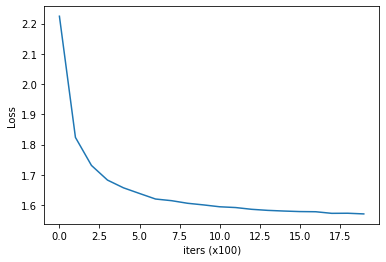

In [42]:
plt.xlabel('iters (x100)')
plt.ylabel('Loss')
plt.plot(all_losses)
plt.show()

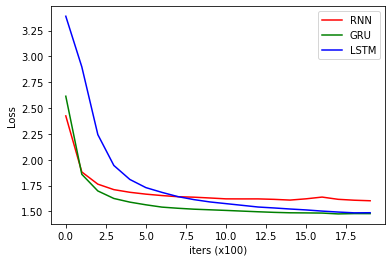

In [10]:
%store -r gru_loss
%store -r lstm_loss

plt.xlabel('iters (x100)')
plt.ylabel('Loss')
plt.plot(all_losses, "-r", label="RNN")
plt.plot(gru_loss, "-g", label="GRU")
plt.plot(lstm_loss, "-b", label="LSTM")
plt.legend(loc="upper right")
plt.show()

#### Generate a Sequence

In [70]:
print(eval_step(net, init_seq='C', predicted_len=600))

Cefvic,, and last just lusselinition.
Nurs from -- OS.
" @ dddmBw:-doneTrump Ten Craused.
The uhs # AmericaGreatAfn wrong than Sumgert underiopen get as there, and how would be sided luffetita Tom power. AMerson Congress hppic, backs with a always in was a side. Market Congress. Meetion to statement high bringer. Wire get better tophinac account...tpatters will have run meen for @ FoxNews
"X win demacturies (will be ramulagion is very saud
Justended out! This s are presidential companies bart on on Trump Can take better.
Presidential right colluded on @ BarackObama's igness Garreth Dondiers who


In [72]:
import os
def save(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(net, save_filename)
    print('Saved as %s' % save_filename)

In [55]:
save("LaTeX_RNN")

Saved as LaTeX_RNN.pt


In [59]:
save("Shakespeare_RNN")

Saved as Shkaespeare_RNN.pt


In [74]:
save("Trump_RNN")

Saved as Trump_RNN.pt


In [28]:
Lrnn = torch.load("LaTeX_RNN.pt")
Lgru = torch.load("LaTeX_GRU.pt")

In [34]:
print(eval_step(Lgru, init_seq='\\begin{document}', predicted_len=600))

\begin{document}

\noindent
Let $f : X \to Y$ easian (Algebra, Lemma \ref{algebra-lemma-arrows-over-descent-has-cartesian-ab-over-completion}
good in $f$ and $\{W_{f_1, i_j!}$ is zariski is locally
of finite modules, Lemmas \ref{remark-finitely-presented-injective}).
Thus we have where the same tey follows
of the lemma). Assume $f$ is a topological space over $B_{p_2}$ of $i_{0, !}$ at asive use
Lemma \ref{lemma-vanishin}.
\end{proof}

\begin{lemma}
\label{lemma-scheme-unions--ut}
Let $f : Y \to X$ be a complex on $X$. By the morphism $f$ of schemes
coverher by Sites, Lemma \ref{sites-definition-characterize}
